In [72]:
using CSV
using DataFrames
using Printf
using JSON
using Statistics
using LinearAlgebra
using JLD2
using PyPlot
using FileIO
include("recsys_funcs.jl")

missing_mean (generic function with 1 method)

create a fake $H$ matrix that obeys a known factorization

In [73]:
n_m = 200
n_g = 150
r = 2
M = randn(r, n_m)
G = randn(r, n_g)
γ = randn(1, n_g)
μ = randn(1, n_m)
h̄ = 0.6

H_truth = M' * G .+ γ .+ μ' .+ h̄

200×150 Array{Float64,2}:
  0.470212  -3.00187     2.43042   …  -4.36483     2.70446    1.85486 
  1.67535   -1.5353     -2.12215      -1.03724     0.172032  -0.872375
  4.84097   -0.0989362   0.786722      1.14818     3.31303    1.82664 
 -0.745089   2.66847     2.05874      -1.61626     1.47185    2.37412 
  3.15355   -1.0725     -0.777296     -0.140538    1.64701    0.343862
  4.45281    2.60447    -0.426492  …   2.94977     2.14011    1.38594 
  2.62096   -0.892959   -0.721984     -0.433691    1.43577    0.336402
  4.10153   -2.23767     0.837261     -0.724251    3.19764    1.39863 
  1.94099    1.45525     1.47575      -0.224184    2.3661     2.15031 
  2.0943    -3.78102     2.35205      -3.64466     3.4258     1.90121 
  0.118236   1.51092    -0.468744  …  -0.845732    0.311513   0.557754
  1.48529   -0.848329   -2.04607      -0.776468    0.082188  -0.731918
  1.80589    1.01078    -0.496676      0.0754908   1.07037    0.69465 
  ⋮                                ⋱               

mask missing values

In [74]:
idx_missing = [rand(1:4) for i = 1:n_m, j = 1:n_g] .== 1
H = deepcopy(H_truth)
H = convert(Array{Union{Float64, Missing}}, H)
# H = copy(H_truth)
# [missing for i = 1:n_m, j = 1:n_g]
H[idx_missing] .= missing
H

200×150 Array{Union{Missing, Float64},2}:
  0.470212  -3.00187    2.43042   …    missing    2.70446    1.85486 
   missing  -1.5353    -2.12215      -1.03724     0.172032  -0.872375
  4.84097     missing    missing      1.14818     3.31303    1.82664 
 -0.745089   2.66847    2.05874        missing    1.47185     missing
  3.15355     missing  -0.777296     -0.140538    1.64701    0.343862
  4.45281    2.60447   -0.426492  …   2.94977      missing   1.38594 
  2.62096   -0.892959  -0.721984     -0.433691    1.43577    0.336402
   missing  -2.23767     missing     -0.724251    3.19764    1.39863 
  1.94099    1.45525    1.47575      -0.224184    2.3661     2.15031 
   missing  -3.78102    2.35205      -3.64466     3.4258      missing
   missing    missing    missing  …    missing    0.311513   0.557754
  1.48529   -0.848329    missing     -0.776468    0.082188    missing
  1.80589     missing    missing      0.0754908   1.07037    0.69465 
  ⋮                               ⋱             

In [104]:
λ₁ = 1000.0
λ₂ = 1000.0

M_p, G_p, μ_p, γ_p, h̄_p, train_rmses, losses = ALS(H, r, [λ₁, λ₂], 
    min_als_sweeps=50, verbose=true, max_als_sweeps=100)

H_predicted = M_p' * G_p .+ h̄_p .+ μ_p' .+ γ_p

M shape: (2, 200)	G shape: (2, 150)
ALS sweep 10
	training loss = 2543.7060021383004
	training RMSE = 0.08562658254527827
ALS sweep 20
	training loss = 2480.5395077430453
	training RMSE = 0.08484393451754686
ALS sweep 30
	training loss = 2469.7095810149935
	training RMSE = 0.08481923655793841
ALS sweep 40
	training loss = 2467.581127325967
	training RMSE = 0.08482736995953342
ALS sweep 50
	training loss = 2467.1306025279127
	training RMSE = 0.08481811965301721
ALS sweep 60
	training loss = 2467.0322450519793
	training RMSE = 0.08483139460888219
loss stopped decreasing


200×150 Array{Float64,2}:
  0.493123  -2.85694     2.35727   …  -4.15099     2.63636    1.80163 
  1.61746   -1.43181    -2.00537      -0.977245    0.18765   -0.802942
  4.67965   -0.0749241   0.773597      1.12091     3.20867    1.77796 
 -0.685066   2.55807     1.98497      -1.50383     1.43038    2.28508 
  3.05477   -1.00904    -0.720228     -0.119008    1.61102    0.35928 
  4.30156    2.52347    -0.389586  …   2.85974     2.07512    1.35865 
  2.53428   -0.828476   -0.668203     -0.397989    1.40237    0.350794
  3.96037   -2.11477     0.813298     -0.676952    3.09011    1.35982 
  1.88959    1.40554     1.44433      -0.188901    2.3009     2.0884  
  2.02017   -3.58193     2.27575      -3.47801     3.31076    1.84274 
  0.138434   1.45241    -0.425235  …  -0.782064    0.323493   0.557454
  1.45086   -0.785291   -1.92459      -0.722307    0.113313  -0.662686
  1.75364    0.984723   -0.45153       0.0954061   1.05067    0.692428
  ⋮                                ⋱               

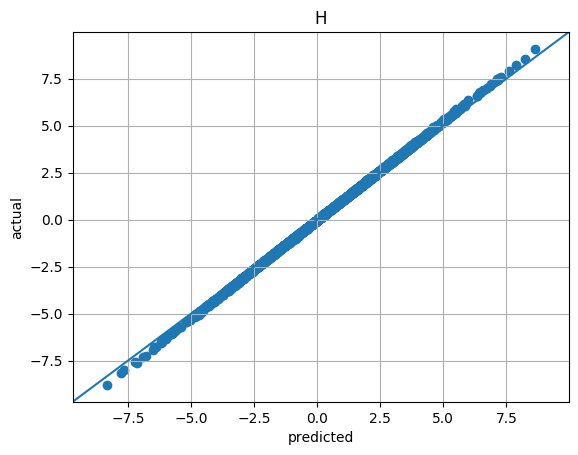

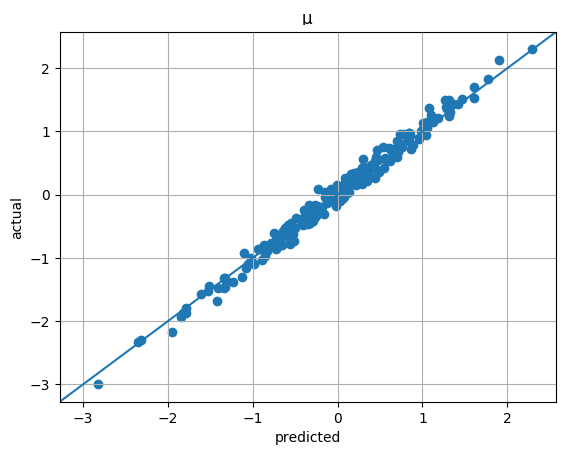

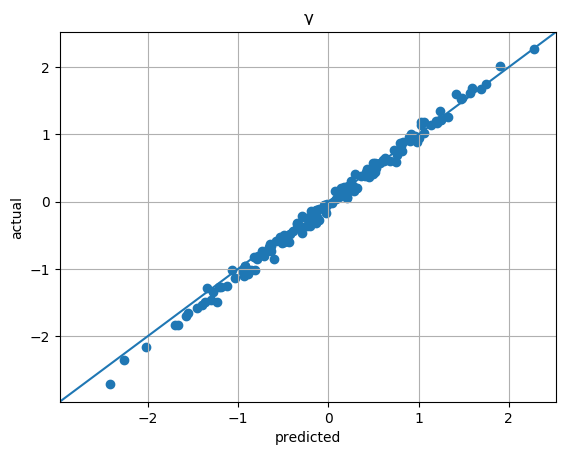

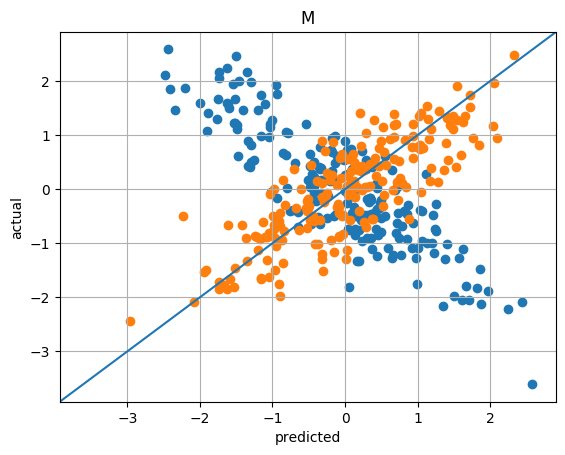

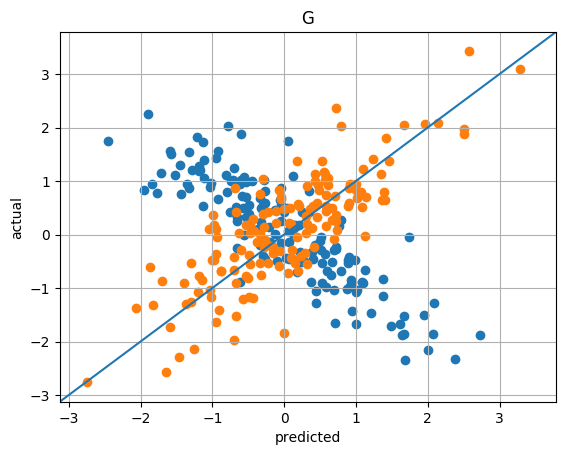

In [105]:
function mk_diagonal()
    lim = ax.get_ylim()
    ax.plot(lim, lim)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
end

fig, ax = plt.subplots()
plt.scatter(H_predicted[idx_missing], H_truth[idx_missing])
plt.grid()
xlabel("predicted")
ylabel("actual")
mk_diagonal()
ax.set_title("H")
plt.show(fig)

    
fig, ax = plt.subplots()
plt.scatter(μ_p, μ)
xlabel("predicted")
ylabel("actual")
mk_diagonal()
plt.grid()
ax.set_title("μ")
plt.show(fig)

fig, ax = plt.subplots()
plt.scatter(γ_p, γ)
xlabel("predicted")
ylabel("actual")
mk_diagonal()
plt.grid()
ax.set_title("γ")
plt.show(fig)

fig, ax = plt.subplots()
plt.scatter(M_p[1, :], M[1, :])
plt.scatter(M_p[2, :], M[2, :])
xlabel("predicted")
mk_diagonal()
ylabel("actual")
plt.grid()
ax.set_title("M")
plt.show(fig)

fig, ax = plt.subplots()
plt.scatter(G_p[1, :], G[1, :])
plt.scatter(G_p[2, :], G[2, :])
xlabel("predicted")
mk_diagonal()
ylabel("actual")
plt.grid()
ax.set_title("G")
plt.show(fig)